# Visualization of major motions via PCA

In [1]:
import pytraj as pt
import numpy as np
#import scipy
import tqdm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

### Set  path to all input files & load trajectories



In [2]:
TOP = 'file.prmtop'
TRAJ = 'file.dcd'
pdb_path = 'reference.pdb' # ref structure

In [3]:
#load traj & refpdb
traj = pt.iterload(TRAJ, TOP, stride=1)
ref = pt.load(filename=pdb_path, top=TOP) 

n_res = traj.top.n_residues
n_frames = traj.n_frames

mask_align = "(:1-2672)&(@N,@O,@C,@CA)" 
maskS1 = '@N,@O,@C,@CA:'+ str(n_res)
pt.superpose(traj, ref=ref, mask=mask_align)
#traj._force_load = True # importand when data exceeds ram

pytraj.TrajectoryIterator, 8000 frames: 
Size: 7.674336 (GB)
<Topology: 42918 atoms, 2677 residues, 13 mols, non-PBC>
           

In [4]:
# change pt object be selecting a mask, also changes TOP
traj_ref = ref[maskS1] 
n_atoms = traj_ref.n_atoms

In [5]:
traj_ref

pytraj.Trajectory, 1 frames: 
Size: 0.000241 (GB)
<Topology: 10789 atoms, 2673 residues, 9 mols, non-PBC>
           

### Load coordinates by chunk 
When trajectory is large, loading frames by chunck is much faster than loading all at once with pytraj!

In [6]:
chunksize = min([200, n_frames])
nchunk = int(np.floor(n_frames/chunksize)) + \
                1 if n_frames%chunksize != 0 \
                else int(np.floor(n_frames/chunksize))
pile = [] 
for i in tqdm.tqdm(range(nchunk)):
    tmp = traj[i*chunksize:min((i+1)*chunksize, n_frames)][maskS1]
    pile.append(tmp.xyz)
  
coords = np.concatenate(pile,axis=0)

100%|██████████| 40/40 [00:10<00:00,  3.98it/s]


In [7]:
#flatten the coordinates
refframe = traj_ref.xyz.reshape(1, n_atoms*3, order='C')
coords = coords.reshape(n_frames, n_atoms*3, order='C')

### Perform PCA

In [8]:
pca = PCA()
dat = pca.fit_transform(coords) 
eigvals = pca.explained_variance_ratio_
eigvecs = pca.components_
print('Coverage',round(sum(eigvals)*100,1))

Coverage 100.0


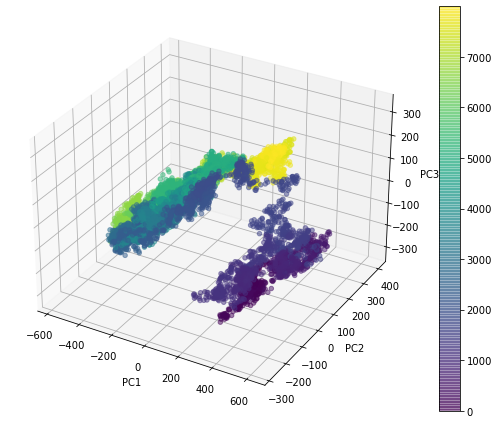

In [9]:
#%matplotlib widget
fig = plt.figure(figsize = [8, 6])
ax = plt.axes(projection = '3d')
p = ax.scatter3D(dat[:,0], dat[:,1], dat[:,2], c = range(int(len(dat))), alpha=0.5)
fig.colorbar(p, ax = ax)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
fig.tight_layout()
plt.savefig('3D_PCA_B1_dBET.png', dpi=600)
plt.show()

In [10]:
eigvals.shape

(8000,)

In [11]:
eigvecs[0,:]

array([-0.00079848, -0.000673  , -0.00062859, ..., -0.00711254,
       -0.00369358, -0.00373702])

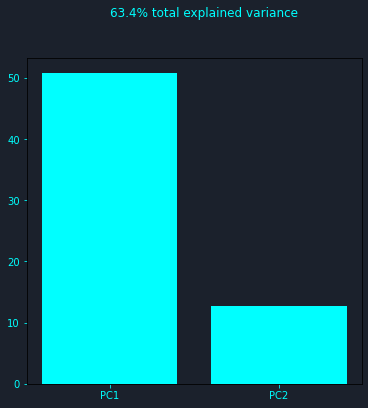

In [13]:
n_comps = 2
bg_cl = '#1b212c'
tcl = 'cyan'
cov = round(sum(eigvals[0:n_comps])*100,1)
x = range(1, n_comps+1)
ticks = ['PC' + str(i) for i in x]

fig = plt.figure(figsize=(6,6), facecolor=bg_cl)
plt.rcParams['axes.facecolor'] = bg_cl
plt.tick_params(colors=tcl)

plt.bar(x, height= eigvals[0:n_comps]*100, tick_label = ticks, color=tcl)
plt.text(1, 60, str(cov)+"% total explained variance", color=tcl, size=12)
plt.savefig('PCA_percentage_B1_dBET.png', dpi=600)

### Motion generation
* Keep all eigenvectors, but change only a few with highest engenvalue to see major mations.
* Increase eigenvector length gradually to induce motion along eigenvector direction. 


In [34]:
eigvecs.shape

(8000, 32376)

In [35]:
n_iters = 100
b,e = 0, 3 # select which component
           # 0,1 -- 1st component
           # 0,3 -- 1st 3 components
           # 9,10 -- 10th component
vecs = eigvecs.copy()
Z = pca.transform(refframe)
Xhat = []
strength = 0.01 # also the strength of motion applied
dv = strength * vecs[b:e,:]
for i in range(n_iters):
    Xhat.append(np.dot(Z, vecs))
    vecs[b:e,:] += dv

Xhat = np.array(Xhat) +  pca.mean_

In [36]:
Xhat.shape

(100, 1, 32376)

In [37]:
#reshape back to nx3
Xhat = Xhat.reshape(n_iters, n_atoms, 3, order='C')

In [38]:
Xhat.shape

(100, 10792, 3)

### Generate .dcd & .prmtop for vmd visualization

In [39]:
out_path = ''
#make new pt object with new frames & updated TOP
traj_new = pt.Trajectory(xyz=Xhat, top=traj_ref.top)
#output traj and TOP
pt.write_traj(out_path +'out.dcd', traj_new, overwrite=True)
pt.write_parm(top=traj_ref.top, filename=out_path + 'new.prmtop', overwrite=True)

## Done! 
